<a href="https://colab.research.google.com/github/guupiii/ESAA/blob/main/ESAA_YB_week11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**09 회귀 실습 - 자전거 대여 수요 예측**

2022년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수.

count : 대여 횟수



**데이터 클랜징 및 가공과데이터 시각화**


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

bike_df = pd.read_csv('/content/drive/MyDrive/MLData/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

Mounted at /content/drive
(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


판다스에서는 datetime과 같은 형태의 문자열을 년도, 월, 일 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 'datetime'타입으로 변경해야 한다. 판다스는 문자열을 datetime 타입으로 변환하는 apply 메서드를 제공한다.

In [4]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


casual과 registered는 따로 필요하지 않고 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 삭제한다.

In [5]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

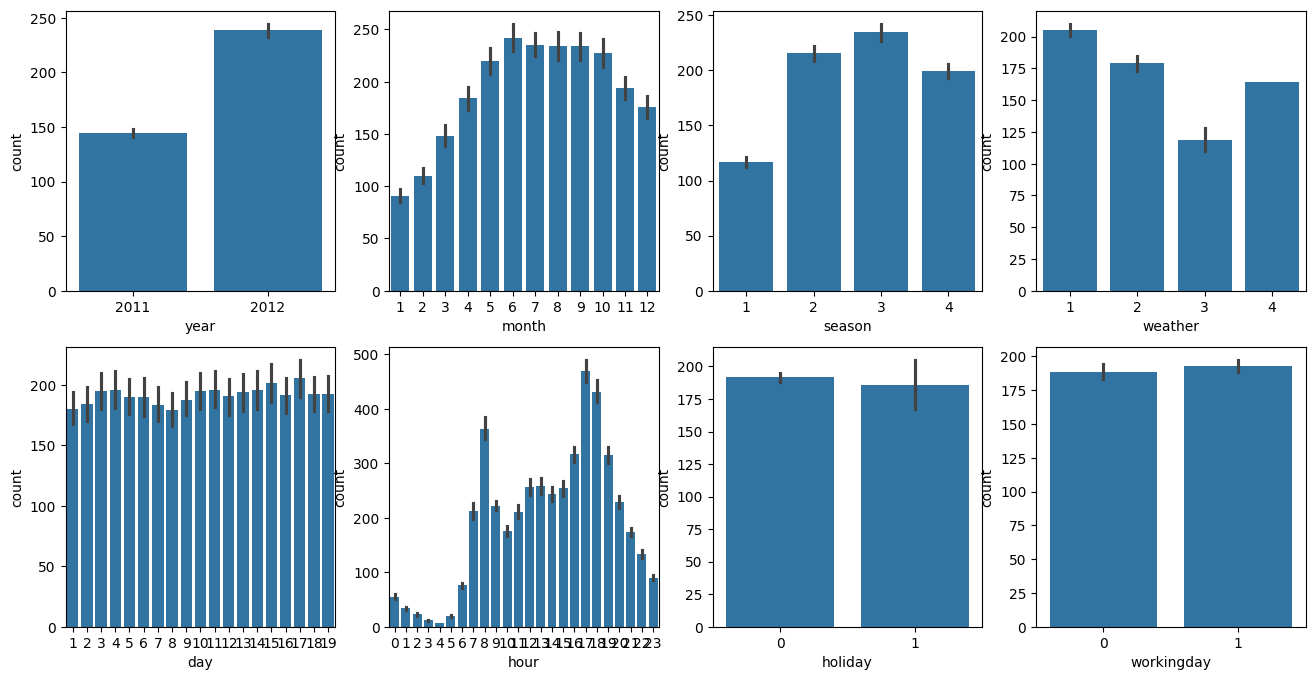

In [6]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

year별 count를 보면 2012년이 2011년보다 상대적으로 값이 높다. 이는 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과라고 여겨질 수 있다.

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

rmsle() 함수를 만들 때 주의할 점은 rmsle를 구할 때 넘파이의 log() 함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수도 있지만 데이터 값의 크기에 따라 오버플로, 언더 플로 오류가 발생하기 쉽다.

In [17]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽습니다.
def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(mse)
    return rmsle

따라서 log()보다는 log1p()를 이용하는데, log1p(x)의 경우는 log(1+x)로 변환되므로 x값이 0이 되더라도 log(0)인 무한대가 되지 않고, log(1)인 0이 되므로 오버플로 언더플로 문제를 해결해 준다. 그리고 log1p()로 변환된 값은 다시 넘파이의 expm1()함수로 쉽게 원래의 스케일로 복원될 수 있다.

**로그 변환, 피처 인코딩, 모델 학습/예측/평가**

회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다. 결괏값이 정규 분포로 돼 있는지 확인하는 것과 카테고리형 회귀모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것이다.

In [19]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [20]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


target 값의 분포는 정규 분포 형태가 가장 좋다.왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다.

<Axes: >

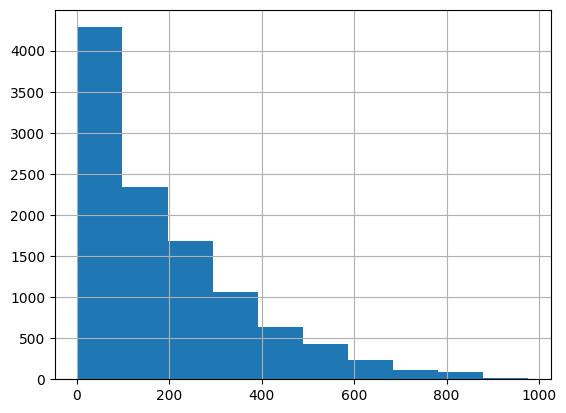

In [21]:
y_target.hist()

이렇게 count값이 정규 분포가 아니고 왜곡되어 있는 경우 로그를 적용해 변환할수 있다.

<Axes: >

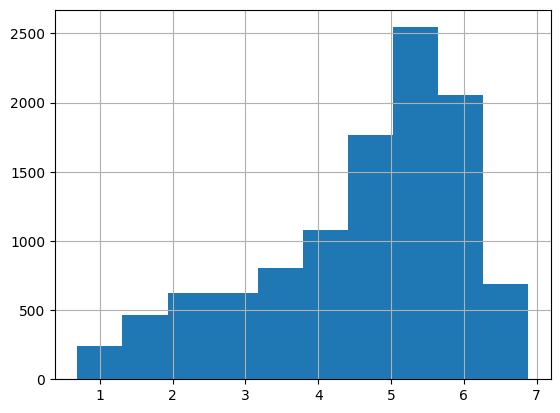

In [22]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [23]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 로그 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 로그 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 스케일변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: ylabel='None'>

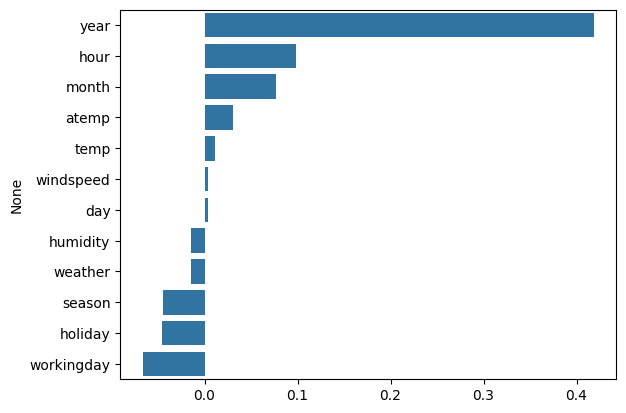

In [24]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야한다.

In [25]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])



In [26]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

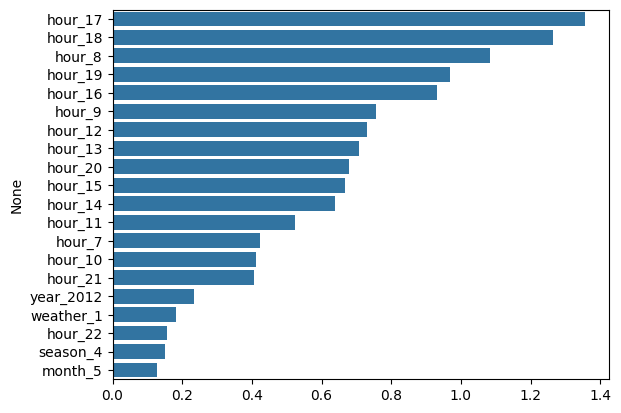

In [27]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.254, MAE: 31.133
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.367, MAE: 32.761
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


앞의 선형 회귀 모델보다 예측 성능이 개선됐다. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아니다. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있다.

##**10 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**

In [39]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/MLData/house_train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [40]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


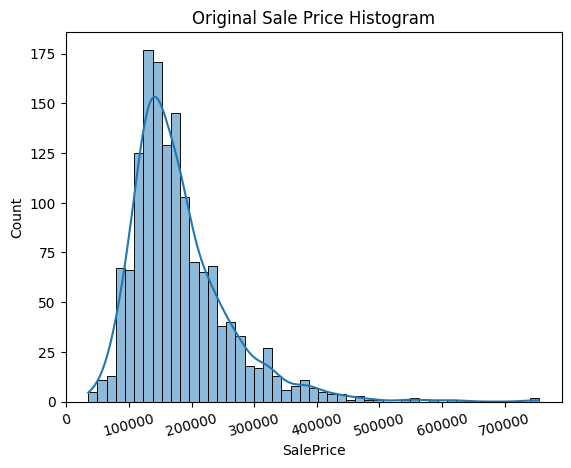

In [41]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

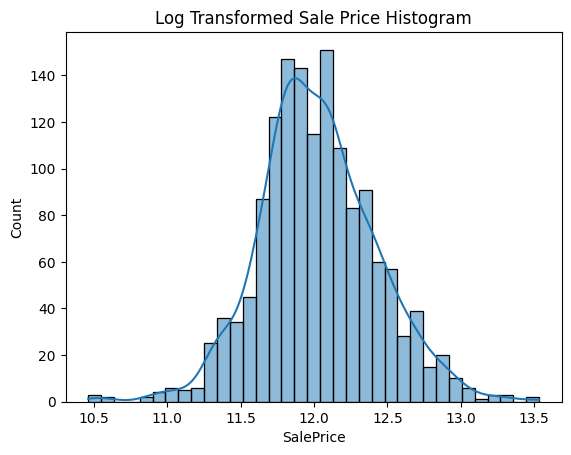

In [42]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [43]:
# SalePrice 로그 변환

original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'],axis=1, inplace=True)
# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체

numerical_cols = house_df.select_dtypes(include=np.number).columns

house_df[numerical_cols] = house_df[numerical_cols].fillna(house_df[numerical_cols].mean())

# Null 값이 있는 피처명과 타입을 추출

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() >0]

print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 모든 인코딩 값이 0으로 변환되는 방식으로 대체해주므로 별도의 Null 값을 대체하는 로직이 필요 없다.

In [44]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])


get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


**선형 회귀 모델의 학습/예측/평가**

실제 값도 로그 변환됐고, 예측값도 이를 반영한 로그 변환 값이므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다.

In [45]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [46]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250701),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

In [47]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low


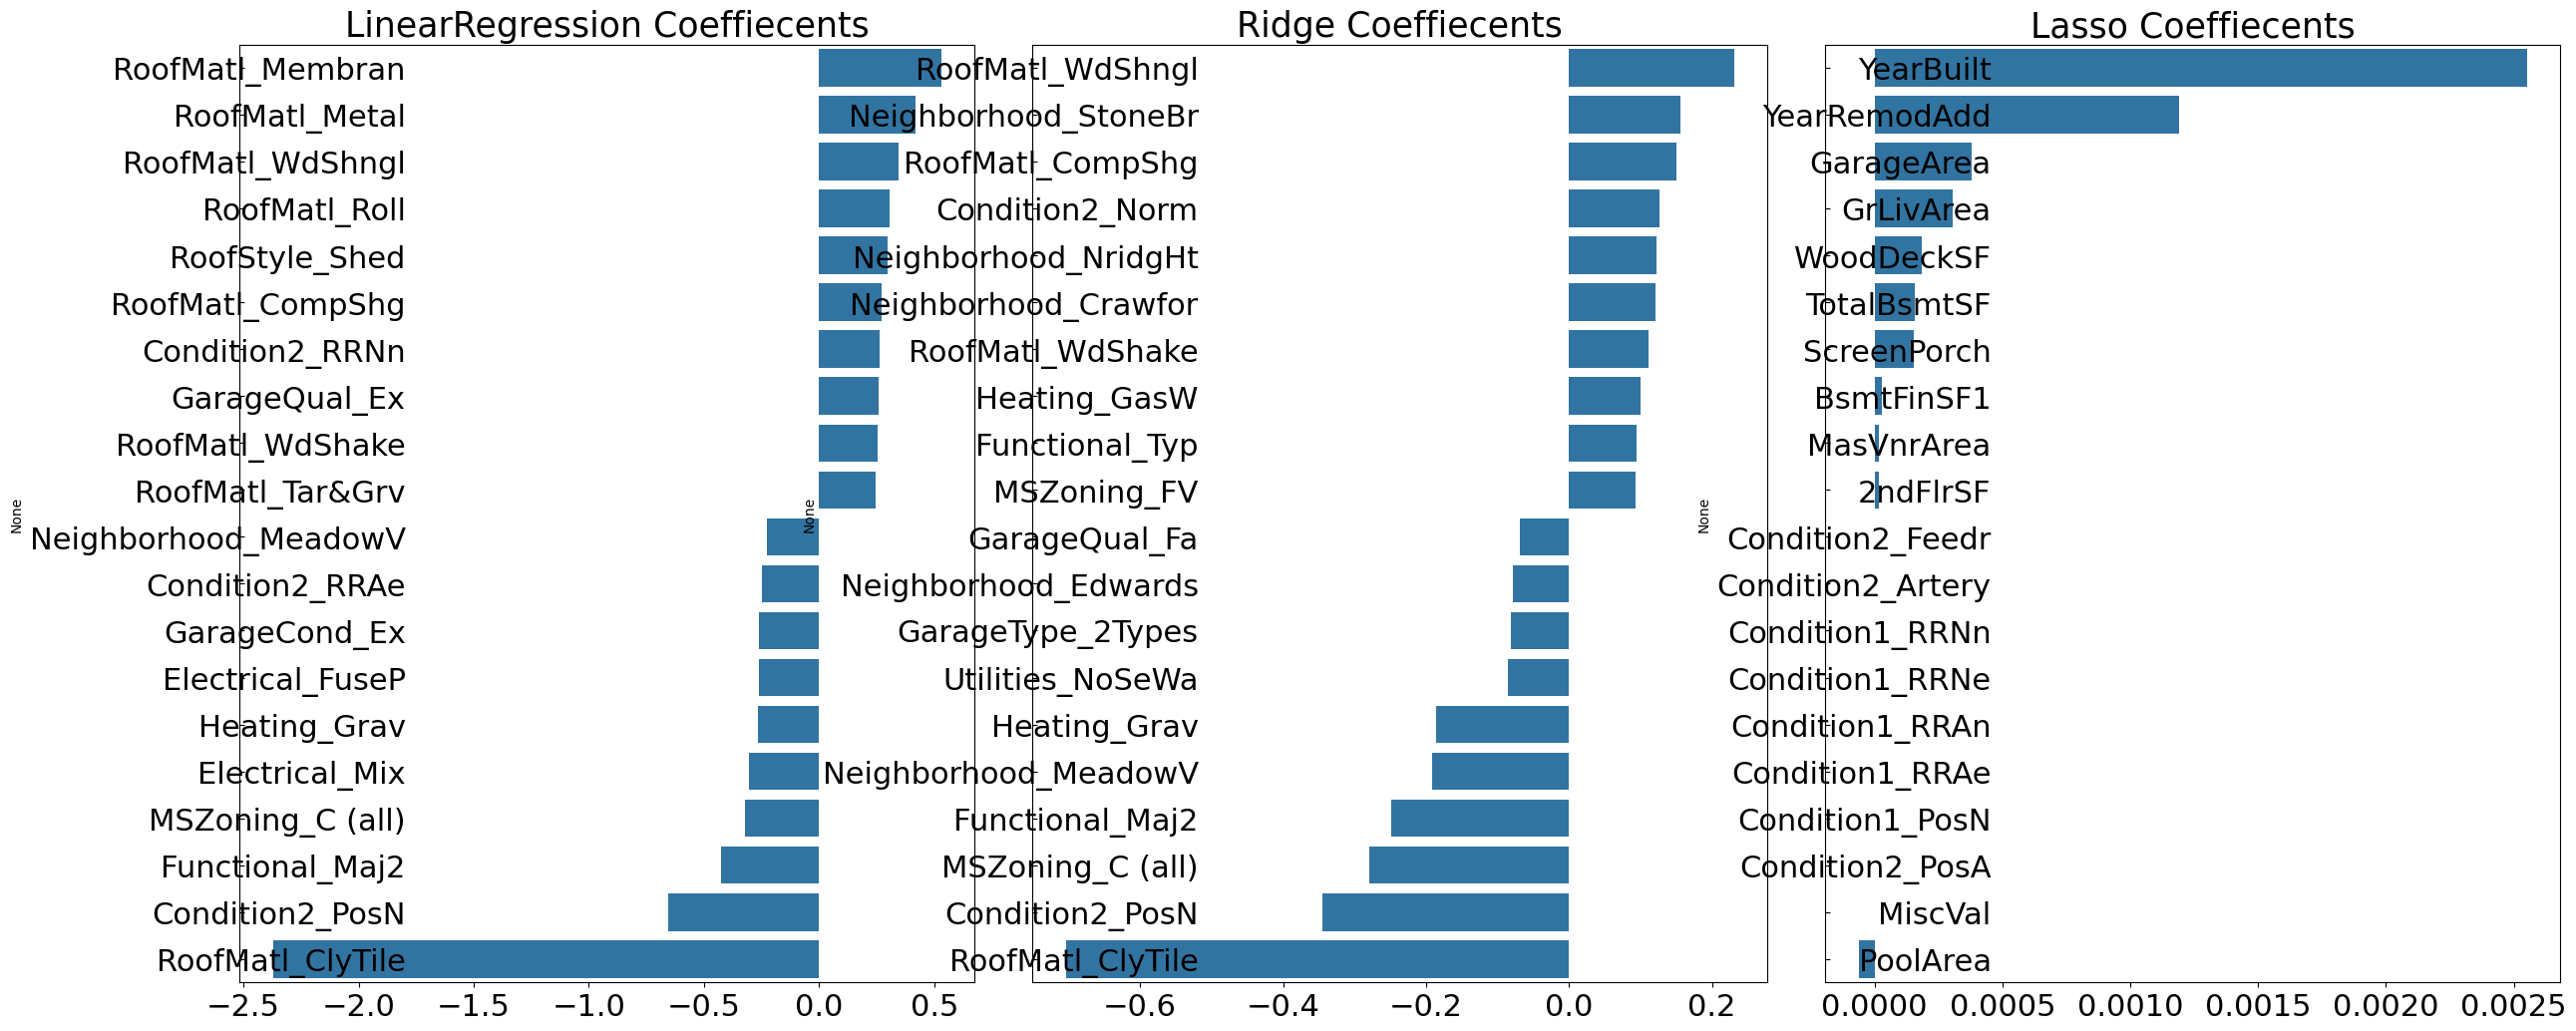

In [48]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)


In [49]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


* 하이퍼 파라미터 튜닝

In [50]:

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


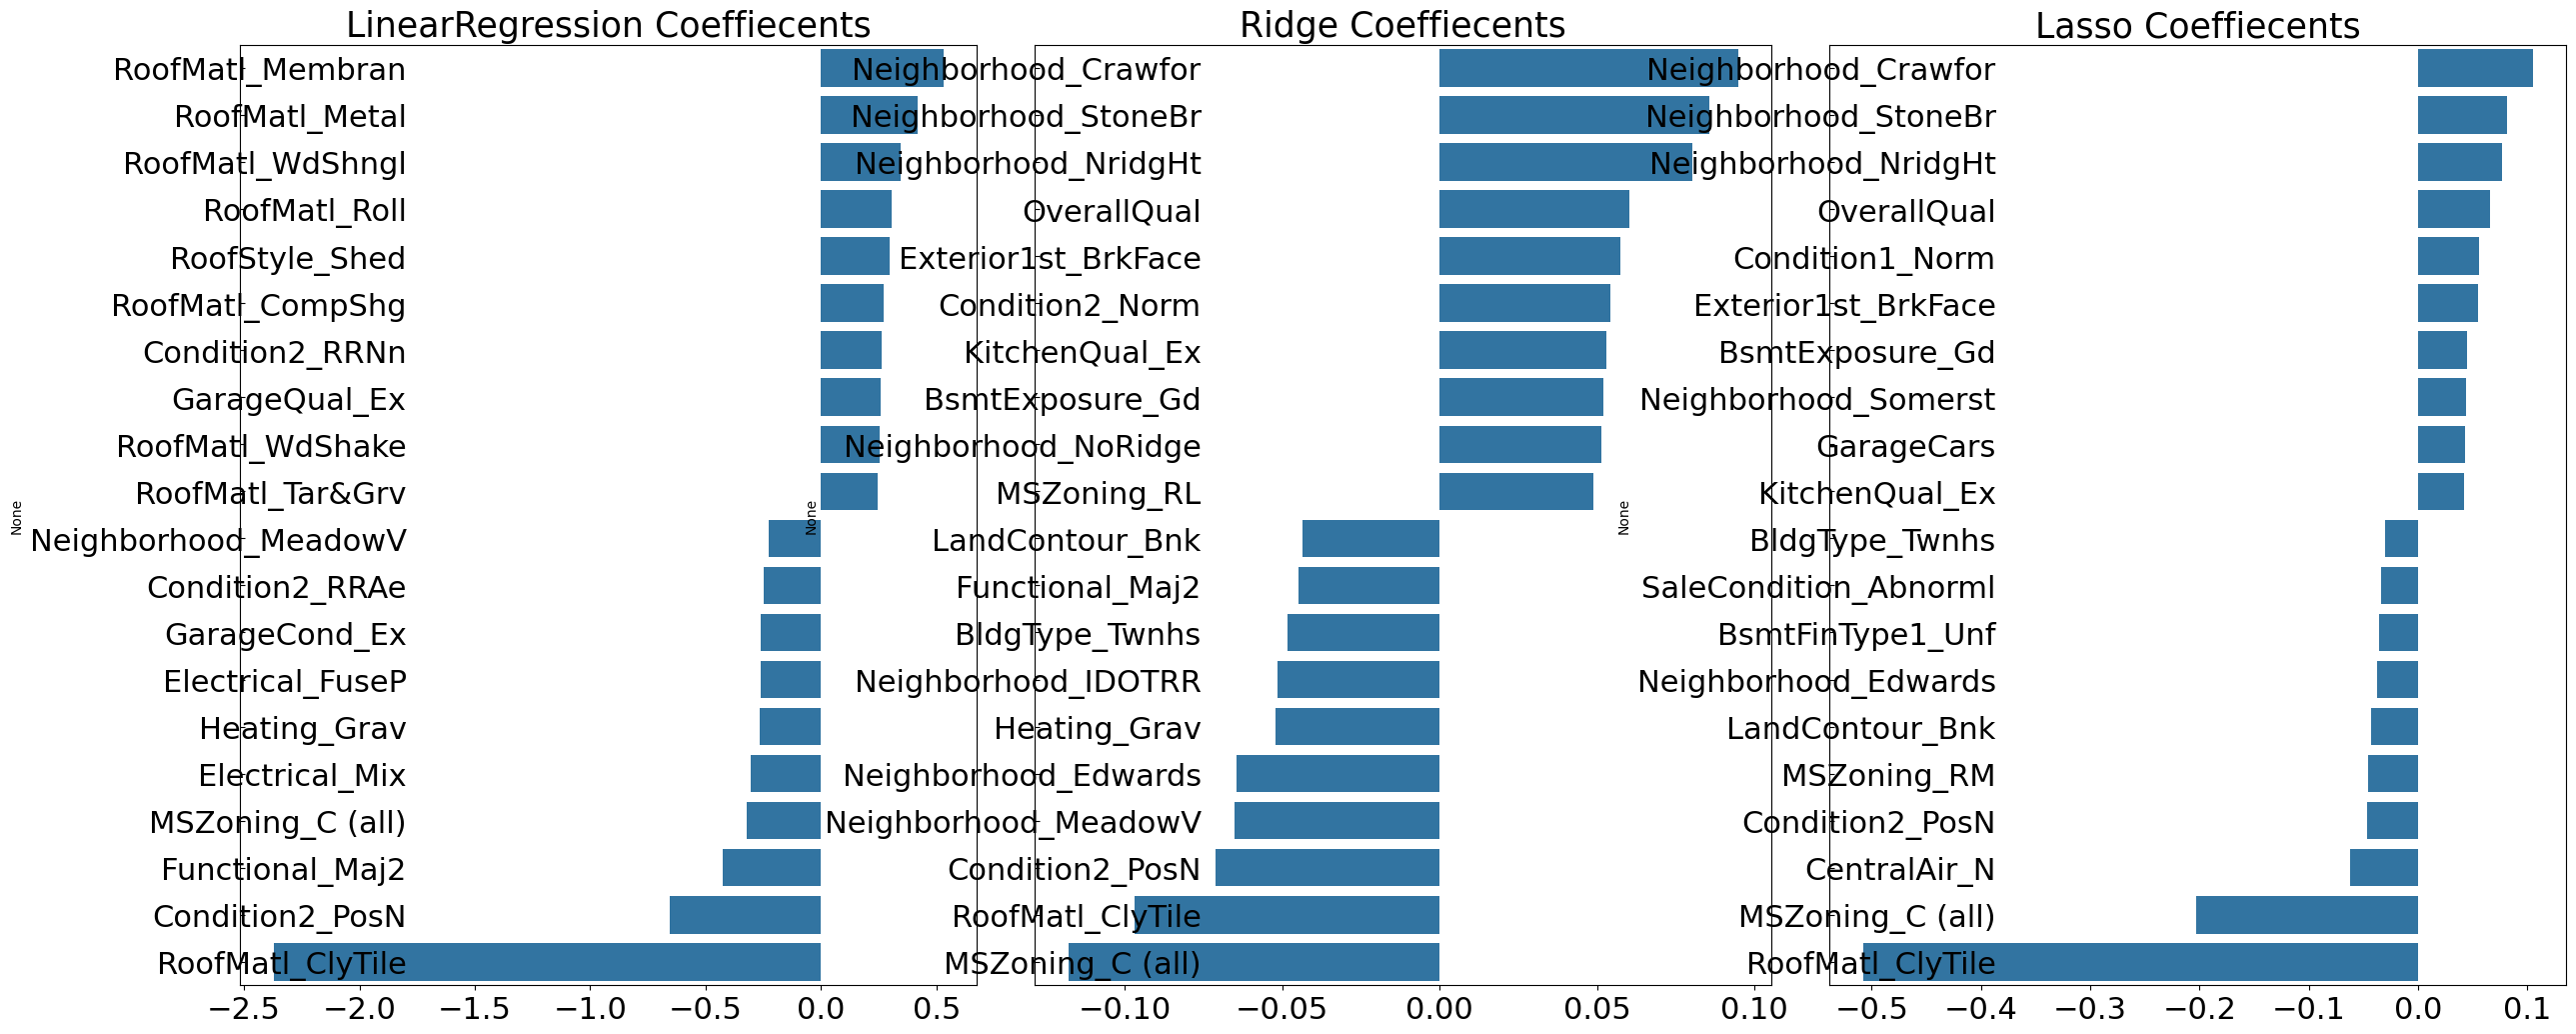

In [51]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

사이파이 stats 모듈의 skew()함수를 이용해 칼럼 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있다. 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단하지만 상황에 따라 편차는 있다. 여기서는 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용한다.

한가지 주의 할 점은 skew() 를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야한다. 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높다.

In [52]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [53]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [54]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


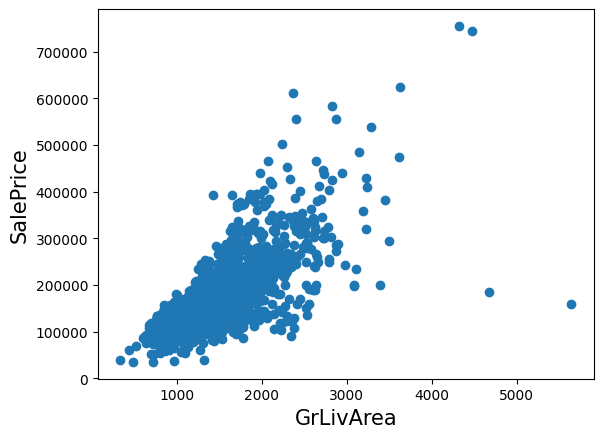

In [55]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


일반적으로 주거공간이 큰 집일 수록 가격이 비싸기 때문에 grlivarea 피처는 saleprice와 양의 상관도가 매우 높음을 직관적으로 알 수 있다. 크게 어긋난 데이터는 이상치로 간주하고 삭제한다.

In [56]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 270)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 270)


In [57]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


데이터 가공은 알고리즘을 적용하기 이전에 수행한다. 하지만 이것이 머신러닝 알고리즘을 적용하기 이전에 완벽하게 데이터의 선처리 작업을 수행하라는 의미는 아니다. 일단 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러 가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모델 생성 과정이다.

**회귀 트리 학습/예측/평가**

In [59]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1206, 최적 alpha:{'n_estimators': 1000}


In [60]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              n_jobs=-1, num_leaves=4, reg_lambda=10, subsample=0.6)

**회귀 모델들의 예측 결과 혼합을 통한 최종 예측**

In [61]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10006075517615193
Ridge 모델의 RMSE: 0.10340697165289348
Lasso 모델의 RMSE: 0.10024171179335342


In [62]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.10215383402419025
XGBM 모델의 RMSE: 0.10761344291735733
LGBM 모델의 RMSE: 0.10363891833477148


**스태킹 모델을 통한 회귀 예측**

In [63]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [64]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)



Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
	 폴드 세트:  1  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

**11 정리**

선형 회귀는 실제 값과 예측값의 차이인 오류를 최소로 줄일 수 있는 선형 함수를 찾아서 이 선형 함수에 독립변수를 입력해 종속변수를 예측하는 것이다.

실제값과 예측값의 차이를 최소화하는 것에만 초점을 맞춘 단순 선형 회귀는 학습 데이터에 과적합되는 문제를 수반할 가능성이 높다. 이러한 과적합 문제를 해결하기 위해 규제를 선형회귀에 도입했다.

로지스틱회귀는 실제로는 분류를 위한 알고리즘이다. 최적의 시그모이드 함수를 도출하고 독립변수를 이 시그모이드 함수에 입력해 반환된 결과를 확률값으로 변환해 예측 레이블을 결정한다.



In [65]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.09704503149148055
